In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.8 MB/s eta 0:00:00


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [ ]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Parameter
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 4
CLASSES = [1, 2, 3, 4]
PALETTE = ['87CEFA', 'D2B48C', 'F08080', '006400']
SAMPLE_PATH = '/content/drive/MyDrive/DL/Samples_Mangaluru_2023.csv'


In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
575,0.043402,0.053302,0.070187,0.051185,0.031468,0.019643,0.012052,-0.052507,0.446117,0.231364,0.380896,-0.231364,0.239470,0,1,train
5185,0.041478,0.058074,0.089300,0.101441,0.197801,0.230760,0.190637,0.175725,0.018442,-0.076906,-0.377920,0.076906,0.095213,12,3,train
5917,0.022145,0.040047,0.078520,0.101318,0.144245,0.165420,0.140917,0.073921,0.011669,-0.068380,-0.295042,0.068380,0.079985,79,3,train
537,0.039965,0.046620,0.066640,0.049865,0.028993,0.019615,0.012135,-0.053326,0.409884,0.192923,0.393668,-0.192923,0.235591,0,1,train
2790,0.012437,0.021664,0.050993,0.033778,0.050827,0.026105,0.015394,0.039069,0.535081,0.321353,0.001621,-0.321353,0.258110,11,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5766,0.041835,0.062845,0.115590,0.175512,0.280288,0.376043,0.252402,0.140673,0.052348,-0.145895,-0.416031,0.145895,0.196740,98,3,train
7126,0.013482,0.022090,0.052862,0.036665,0.284137,0.139487,0.062267,0.462236,0.640493,0.341458,-0.686276,-0.341458,0.382741,23,4,train
1562,0.067575,0.073130,0.083236,0.060549,0.039855,0.023767,0.015022,-0.060531,0.452508,0.252859,0.352432,-0.252859,0.225445,0,1,train
6993,0.023479,0.031729,0.063024,0.071755,0.243451,0.224559,0.138264,0.298911,0.275566,0.040368,-0.588718,-0.040368,0.237844,22,3,test


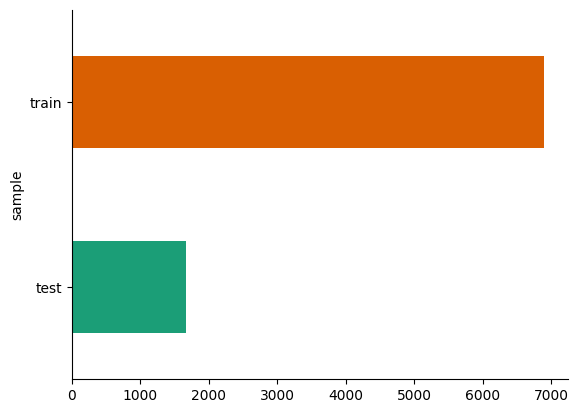

In [ ]:
# @title sample

from matplotlib import pyplot as plt
import seaborn as sns
samples.groupby('sample').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1, int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1, int)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (6898, 14, 1)
Test features: (1675, 14, 1)
Train label: (6898, 5)
Test label: (1675, 5)


In [ ]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.2
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 64)            192       
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            8256      
                                                                 
 max_pooling1d (MaxPooling1  (None, 6, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 128)            16512     
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 128)            32896     
                                                        

In [ ]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
7/7 [==============================] - 8s 133ms/step - loss: 1.4514 - accuracy: 0.4810 - val_loss: 1.3440 - val_accuracy: 0.6716
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 1.2120 - accuracy: 0.6421 - val_loss: 0.9901 - val_accuracy: 0.7349
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.8715 - accuracy: 0.6522 - val_loss: 0.7798 - val_accuracy: 0.5791
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.7715 - accuracy: 0.6615 - val_loss: 0.6864 - val_accuracy: 0.8334
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6627 - accuracy: 0.7230 - val_loss: 0.6670 - val_accuracy: 0.7910
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.5761 - accuracy: 0.7834 - val_loss: 0.5234 - val_accuracy: 0.8555
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.4686 - accuracy: 0.8389 - val_loss: 0.4113 - val_accuracy: 0.8663
Epoch 8/100
7/7 [==

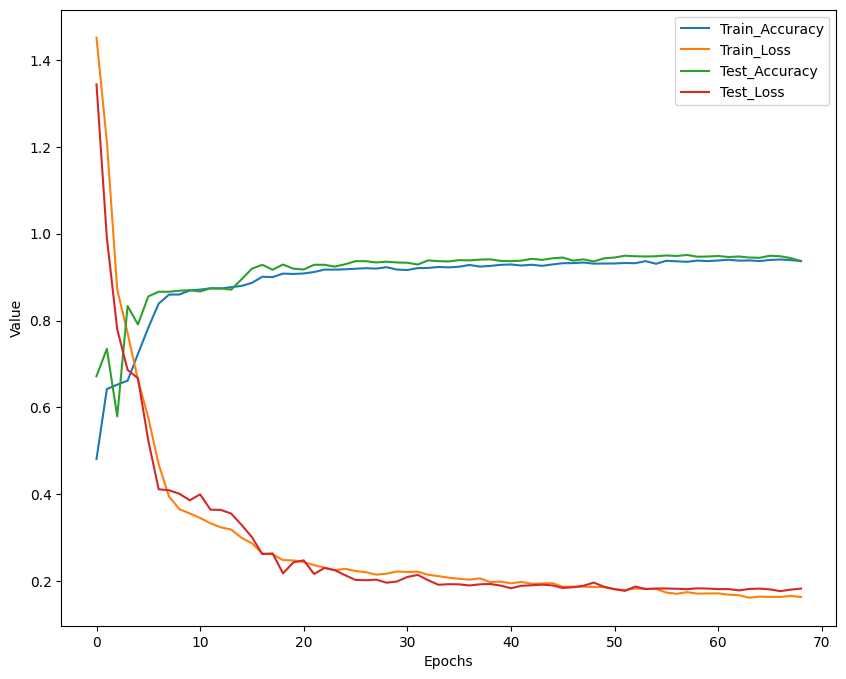

In [ ]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

53/53 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       620
           2       0.90      0.66      0.76       158
           3       0.93      0.96      0.95       736
           4       0.80      0.88      0.84       161

    accuracy                           0.94      1675
   macro avg       0.91      0.87      0.88      1675
weighted avg       0.94      0.94      0.94      1675



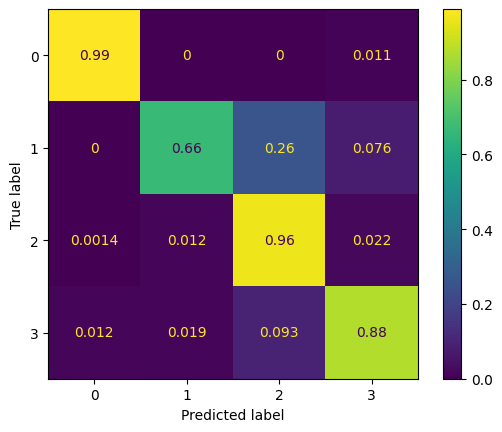

In [ ]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

In [ ]:
# Save model
model.save('/content/drive/MyDrive/DL/LULC.h5')

# Save model
model.save('LULC.h5')
model.save('LULC.keras')
# Download to local system
from google.colab import files
files.download('LULC.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
IMAGE23_PATH = '/content/drive/MyDrive/DL/Landsat_Mangaluru_2023.tif'
IMAGE15_PATH = '/content/drive/MyDrive/DL/Landsat_Mangaluru_2015.tif'

/usr/local/lib/python3.10/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


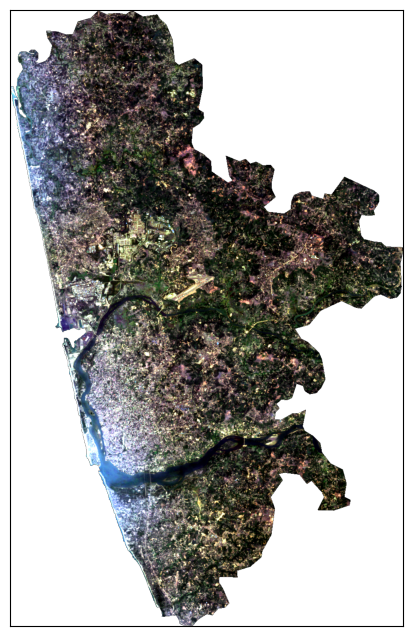

<Axes: >

In [ ]:
# Load image
image = rasterio.open(IMAGE23_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [4, 3, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

16/16 [==============================] - 2s 87ms/step


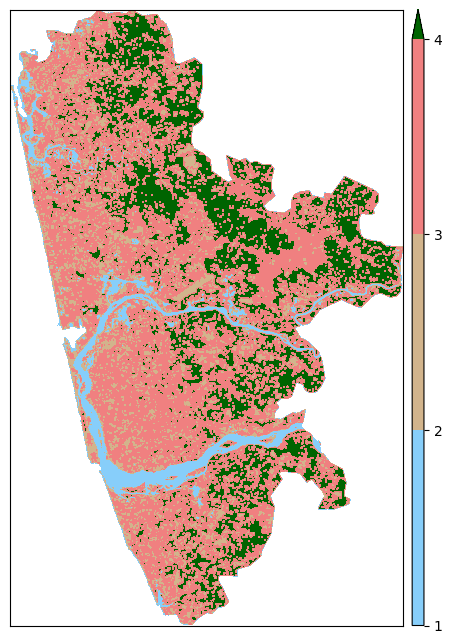

<Axes: >

In [ ]:
# Predict image using the model

image_input = []
for x in range(14):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(14, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

import matplotlib.colors as mcolors

# Normalize hexadecimal color values to RGBA
PALETTE_normalized = [mcolors.hex2color('#' + color) for color in PALETTE]

# Visualization
cmap, norm = mcolors.from_levels_and_colors(CLASSES, PALETTE_normalized, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)


In [ ]:
import rasterio

# Define the save location and filename
save_location = '/content/drive/MyDrive/DL/'
name = 'Mangaluru_2023_CNN.tif'
location = save_location + name

# Specify CRS as EPSG:4326 (WGS 84)
crs = 'EPSG:4326'

# Open a new GeoTIFF file in write mode
with rasterio.open(
    location,
    mode='w',
    driver='GTiff',
    height=prediction.shape[0],
    width=prediction.shape[1],
    count=1,  # Number of bands
    dtype='float32',  # Specify float32 data type
    crs=crs,  # Specify CRS
    transform=transform  # Affine transform
) as new_dataset:
    # Write the predicted values to the GeoTIFF file
    new_dataset.write(prediction.astype('float32'), 1)


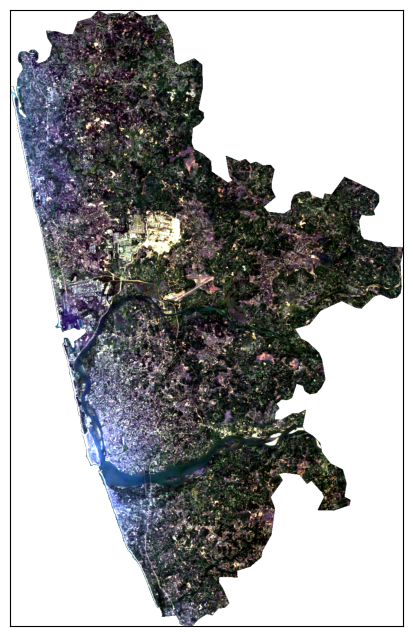

<Axes: >

In [ ]:
# Load image
image1 = rasterio.open(IMAGE15_PATH)
bandNum = image1.count
height = image1.height
width = image1.width
crs = image1.crs
transform = image1.transform
shape = (height, width)

image1_vis = []
for x in [4, 3, 2]:
  image1_vis.append(image1.read(x))
image1_vis = np.stack(image1_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image1_vis,
  figsize=plot_size,
  stretch=True,
)

16/16 [==============================] - 1s 63ms/step


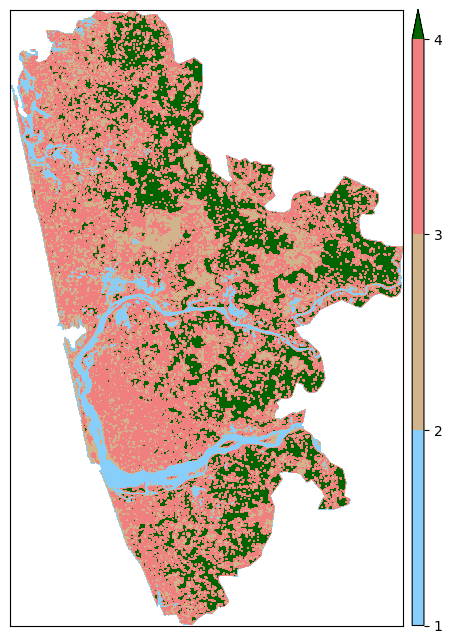

<Axes: >

In [ ]:
# Predict image using the model

image1_input = []
for x in range(14):
  image1_input.append(image1.read(x + 1))
image1_input = reshape_input(np.stack(image1_input).reshape(14, -1).T)

# Predict
prediction = model.predict(image1_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

import matplotlib.colors as mcolors

# Normalize hexadecimal color values to RGBA
PALETTE_normalized = [mcolors.hex2color('#' + color) for color in PALETTE]

# Visualization
cmap, norm = mcolors.from_levels_and_colors(CLASSES, PALETTE_normalized, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)


In [ ]:
import rasterio

# Define the save location and filename
save_location = '/content/drive/MyDrive/DL/'
name = 'Mangaluru_2015_CNN.tif'
location = save_location + name

# Specify CRS as EPSG:4326 (WGS 84)
crs = 'EPSG:4326'

# Open a new GeoTIFF file in write mode
with rasterio.open(
    location,
    mode='w',
    driver='GTiff',
    height=prediction.shape[0],
    width=prediction.shape[1],
    count=1,  # Number of bands
    dtype='float32',  # Specify float32 data type
    crs=crs,  # Specify CRS
    transform=transform  # Affine transform
) as new_dataset:
    # Write the predicted values to the GeoTIFF file
    new_dataset.write(prediction.astype('float32'), 1)


In [ ]:
IMAGE20_PATH = '/content/drive/MyDrive/DL/Landsat_Mangaluru_2020.tif'

/usr/local/lib/python3.10/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


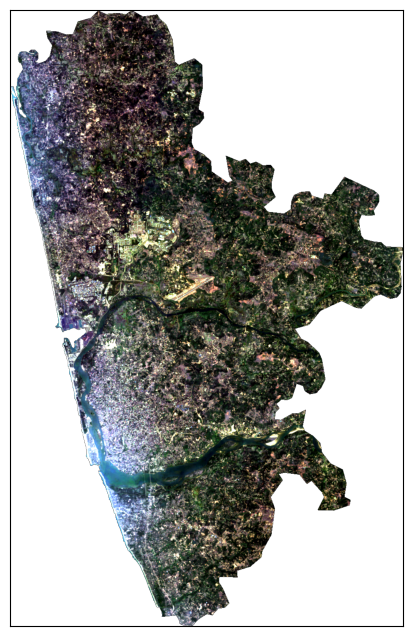

<Axes: >

In [ ]:
# Load image
image2 = rasterio.open(IMAGE20_PATH)
bandNum = image2.count
height = image2.height
width = image2.width
crs = image2.crs
transform = image2.transform
shape = (height, width)

image2_vis = []
for x in [4, 3, 2]:
  image2_vis.append(image2.read(x))
image2_vis = np.stack(image2_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image2_vis,
  figsize=plot_size,
  stretch=True,
)

16/16 [==============================] - 2s 84ms/step


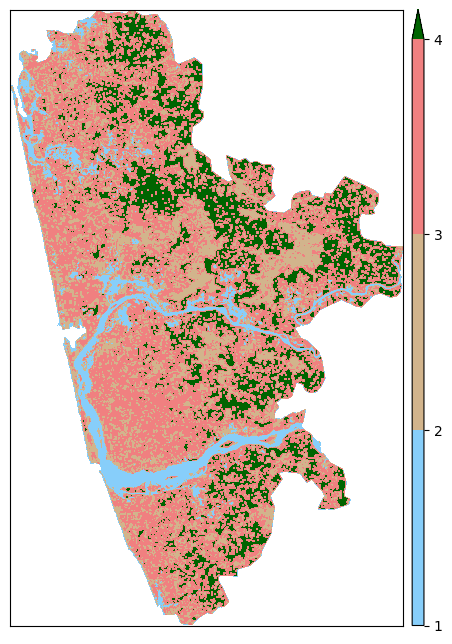

<Axes: >

In [ ]:
# Predict image using the model

image2_input = []
for x in range(14):
  image2_input.append(image2.read(x + 1))
image2_input = reshape_input(np.stack(image2_input).reshape(14, -1).T)

# Predict
prediction = model.predict(image2_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

import matplotlib.colors as mcolors

# Normalize hexadecimal color values to RGBA
PALETTE_normalized = [mcolors.hex2color('#' + color) for color in PALETTE]

# Visualization
cmap, norm = mcolors.from_levels_and_colors(CLASSES, PALETTE_normalized, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)


In [ ]:
import rasterio

# Define the save location and filename
save_location = '/content/drive/MyDrive/DL/'
name = 'Mangaluru_2020_CNN.tif'
location = save_location + name

# Specify CRS as EPSG:4326 (WGS 84)
crs = 'EPSG:4326'

# Open a new GeoTIFF file in write mode
with rasterio.open(
    location,
    mode='w',
    driver='GTiff',
    height=prediction.shape[0],
    width=prediction.shape[1],
    count=1,  # Number of bands
    dtype='float32',  # Specify float32 data type
    crs=crs,  # Specify CRS
    transform=transform  # Affine transform
) as new_dataset:
    # Write the predicted values to the GeoTIFF file
    new_dataset.write(prediction.astype('float32'), 1)


In [ ]:
## Future LULC prediction

In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

# Import packages
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/DL/Samples_Mangaluru_2023.csv')

# Separate features and labels
features = data.drop(columns=['classvalue', 'sample'])
labels = data['classvalue']
samples = data['sample']

# Normalize only the numeric features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Combine the scaled features with the labels and samples
data_scaled = pd.DataFrame(features_scaled, columns=features.columns)
data_scaled['classvalue'] = labels
data_scaled['sample'] = samples

# Create sequences for CNN-LSTM model
def create_sequences(data, num_time_steps):
    X, y, years = [], [], []
    for i in range(len(data) - num_time_steps):
        X.append(data.iloc[i:i + num_time_steps, :-2].values)  # Features
        y.append(data.iloc[i + num_time_steps - 1, -2])  # Target class
        years.append(data.iloc[i + num_time_steps - 1, -1])  # Year label
    return np.array(X), np.array(y), years

num_time_steps = 5  # Define the number of time steps
X, y, years = create_sequences(data_scaled, num_time_steps)

# Reshape input to be [samples, time steps, features]
X_reshaped = X.reshape((X.shape[0], num_time_steps, X.shape[2]))

# Define the CNN-LSTM model
model = Sequential()
model.add(TimeDistributed(Conv1D(32, 3, activation='relu'), input_shape=(num_time_steps, X.shape[2], 1)))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_reshaped, y, epochs=10, batch_size=16, validation_split=0.2)

# Predict future LULC
# Prepare X_future similarly as X
X_future = np.array(['/content/drive/MyDrive/DL/Samples_Mangaluru_2023.csv'])  # Shape (1, num_time_steps, X.shape[2])
y_future = model.predict(X_future)

# Determine the predicted year
predicted_year = years[-1] + (future_time_step_interval * len(y_future))

print(f"Predicted LULC for the year: {predicted_year}")


Epoch 1/10
429/429 [==============================] - 6s 7ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
429/429 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
429/429 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/10
429/429 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/10
429/429 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/10
429/429 [==============================] - 3s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/10
429/429 [==============================] - 3s 6ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "time_distributed" is incompatible with the layer: expected ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None
